In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [22]:
df = pd.read_parquet('../Dataframes/df.parquet.gzip')

In [23]:
need_num = 500 # Number of data points for validation/ testing
training_num = 1500
epoch = 10
batch_size = 512
capital = 1000000


data = df
dataset = data.iloc[:, 9:10].values
training_dataset = dataset[:training_num]
sc = MinMaxScaler(feature_range = (-1, 1))


training_dataset_scaled = sc.fit_transform(X=training_dataset)

In [24]:
training_dataset.shape

(1500, 1)

In [38]:
x_train = []
y_train = []

for i in range(need_num, training_dataset_scaled.shape[0]):
	x_train.append(training_dataset_scaled[i - need_num : i])
	y_train.append(training_dataset_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [27]:
file = "./Models/" + "GBPUSD" + ".model"
model = None
if os.path.exists(file):
	model = load_model(file)
else:
	model = Sequential()
	model.add(LSTM(units = 128, return_sequences = True, input_shape = [x_train.shape[1], 1]))
	model.add(BatchNormalization())

	model.add(LSTM(units = 128))
	model.add(BatchNormalization())

	model.add(Dense(units = 1))

	model.compile(loss = "mse", optimizer = "rmsprop")
	model.fit(x_train, y_train, epochs = epoch, batch_size = batch_size)

	model.save(file)


inputs = dataset[training_num - need_num:]
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

predictions = []



for i in range(need_num, inputs.shape[0]):
	predictions.append(inputs[i - need_num: i, 0])

predictions = np.array(predictions)
predictions = np.reshape(predictions, (predictions.shape[0], predictions.shape[1], 1))


real_price = dataset[training_num:]
predicted_price = model.predict(predictions)

Epoch 1/10
1000/1000 [==============================] - 23s 23ms/step - loss: 7.4267
Epoch 2/10
1000/1000 [==============================] - 21s 21ms/step - loss: 2.9914
Epoch 3/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.4481
Epoch 4/10
1000/1000 [==============================] - 19s 19ms/step - loss: 0.2260
Epoch 5/10
 512/1000 [==============>...............] - ETA: 12s - loss: 0.1940

KeyboardInterrupt: 

In [12]:
dataset[-need_num:]

array([[ 10.5       ],
       [  6.48148148],
       [ 53.7037037 ],
       [ 58.7962963 ],
       [ 15.24390244],
       [ 49.3902439 ],
       [ 50.6097561 ],
       [ 45.12195122],
       [ 57.53424658],
       [ 49.09090909],
       [ 44.94382022],
       [ 47.72727273],
       [ 68.36734694],
       [ 88.70967742],
       [ 85.30805687],
       [ 79.08163265],
       [ 95.68965517],
       [ 55.50458716],
       [ 66.30434783],
       [ 64.40677966],
       [ 61.86440678],
       [ 38.13559322],
       [ 24.03846154],
       [ 62.5       ],
       [ 95.1048951 ],
       [ 92.26519337],
       [ 92.26519337],
       [ 77.0661157 ],
       [ 88.20638821],
       [ 66.5158371 ],
       [ 98.3935743 ],
       [ 90.        ],
       [ 95.41484716],
       [ 59.88142292],
       [ 62.70491803],
       [ 36.82983683],
       [ 45.75342466],
       [ 57.80821918],
       [ 93.44262295],
       [ 50.67114094],
       [  1.23839009],
       [ 25.56561086],
       [ 10.18099548],
       [ 17

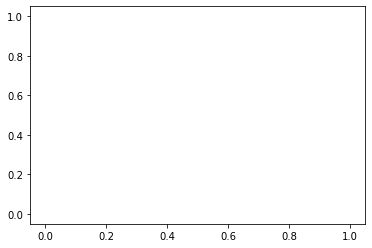

In [15]:
def predict(dataset):
	latest = dataset[-need_num:]

	for i in range(need_num):
		tmp = latest[np.newaxis,:,:]
		cur = (model.predict(tmp) * 0.1 + 1) * (latest[-1][0])
		latest = np.append(latest[1:], cur, axis = 0)

	plt.plot(latest, color = 'blue', label = 'predicted price')

predict(dataset)

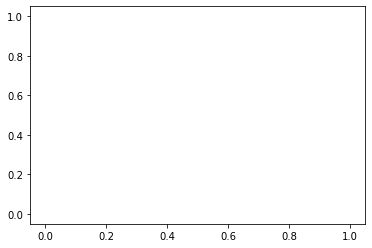

In [16]:
predict(dataset)

0.04792788050560681


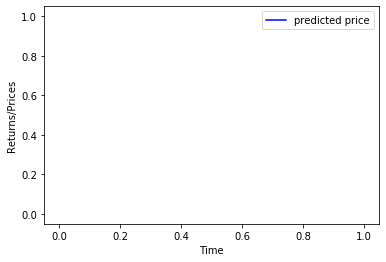

'\npredicted_price = sc.inverse_transform(predicted_price)\nplt.plot(real_price, color=\'red\', label=\'Real Stock Price\')\nplt.plot(predicted_price, color=\'blue\', label=\'Predicted Stock Price\')\nplt.title(label = ticker + " prediction")\nplt.xlabel(xlabel=\'Time\')\nplt.ylabel(ylabel= ticker + \' Stock Price\')\nplt.legend()\nplt.show()\n'

In [7]:
#calculate charpe
def calc_sharpe(d, predicted_price):
	data = d.copy()
	data = data.iloc[training_num:]
	data['alpha'] = pd.DataFrame(predicted_price.flatten())
	data['allocated_capital'] = capital * data['alpha']
	data['pct_change'] = data['close'].pct_change()
	data['daily_pnl'] = data['allocated_capital'] * data['pct_change']

	#plt.plot(data['daily_pnl'].cumsum(), color = 'red', label = 'predicted pnl')

	return np.sqrt(252) * data['daily_pnl'].mean() / data['daily_pnl'].std()


print(calc_sharpe(data, predicted_price))


plt.xlabel(xlabel = 'Time')
plt.ylabel(ylabel = 'Returns/Prices')
plt.legend()
plt.show()


'''
predicted_price = sc.inverse_transform(predicted_price)
plt.plot(real_price, color='red', label='Real Stock Price')
plt.plot(predicted_price, color='blue', label='Predicted Stock Price')
plt.title(label = ticker + " prediction")
plt.xlabel(xlabel='Time')
plt.ylabel(ylabel= ticker + ' Stock Price')
plt.legend()
plt.show()
'''